### Random Forest with RNA only

In [1]:
# perfom tuning of the hyper-parameter 
# difference between hyper and model parameter -> model parameter: configuration
# variable internal of a model whose value can be estimated from data
# hyper parameter: external, value can not be estimated from data
# used https://www.kaggle.com/kanncaa1/feature-selection-and-data-visualization

# libraries 
#from google.colab import files 
import pandas as pd
import numpy as np
import seaborn as sns # data visualization library 
import matplotlib.pyplot as plt
from pprint import pprint
import sklearn
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, r2_score, roc_auc_score, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_blobs
from rfpimp import permutation_importances
seed = 7

In [2]:
#!pip install rfpimp
#pip install pandas==1.0.1
#!pip install git+ssh://git@github.com/pandas-dev/pandas.git@1.0.x

In [3]:
df = pd.read_csv("gene_summary.txt", sep="\t", index_col=0)

In [4]:
def change_labels(x):
  print(x)
  if 'AD' in x:
    return 1
  return 0

In [5]:
print(df.shape)

(27130, 30)


In [6]:
print(df.head(20))

           21-1A-AD  20-1T-AD  23-2A-AD  22-2T-AD  26-3A-AD  24-3T-AD  \
refGene                                                                 
SGIP1          1137      1633       900      1398      1257       858   
NECAP2          270       261       353       395       326       388   
AZIN2           217       300       229       458       258       209   
AGBL4           144       139       134       100       136        44   
CLIC4           871       770      1067      3641       879       937   
SLC45A1         179       306       207       227       220       174   
TGFBR3          633       476       746       495       419       365   
DBT             532       608       719       517       603       393   
PRUNE1          244       254       205       228       281       257   
C1orf21        1835      2452      2194      1448      2244      2081   
RFWD2           417       484       507       468       464       475   
LIN9             53        49        51        25  

In [7]:
print(df.describe())

            21-1A-AD       20-1T-AD       23-2A-AD       22-2T-AD  \
count   27130.000000   27130.000000   27130.000000   27130.000000   
mean      390.385146     443.332436     424.012459     535.622189   
std      2531.586111    2074.966307    2414.071081    3456.987415   
min         0.000000       0.000000       0.000000       0.000000   
25%         2.000000       2.000000       2.000000       2.000000   
50%        51.000000      53.000000      59.000000      60.000000   
75%       320.000000     366.000000     360.000000     402.000000   
max    320795.000000  224850.000000  301019.000000  306188.000000   

            26-3A-AD       24-3T-AD       27-5A-AD       25-5T-AD  \
count   27130.000000   27130.000000   27130.000000   27130.000000   
mean      464.482823     411.720015     349.693918     453.947328   
std      2878.542321    3211.355907    2095.245447    4294.041359   
min         0.000000       0.000000       0.000000       0.000000   
25%         2.000000       2.0000

In [8]:
df_T = df.T
df_T["class"] = df_T.apply(lambda x: change_labels(x.name), axis=1)

21-1A-AD
20-1T-AD
23-2A-AD
22-2T-AD
26-3A-AD
24-3T-AD
27-5A-AD
25-5T-AD
29-6T-AD
31-7T-AD
28-8T-AD
30-9T-AD
18-10A-Old
11-10T-Old
19-11A-Old
13-11T-Old
15-13T-Old
16-14T-Old
12-6A-Old
14-7A-Old
10-8A-Old
17-9A-Old
2-12A-Young
4-13A-Young
6-14A-Young
8-15A-Young
9-16A-Young
3-17T-Young
5-18T-Young
7-19T-Young


In [9]:
df_T.fillna(0)

refGene,SGIP1,NECAP2,AZIN2,AGBL4,CLIC4,SLC45A1,TGFBR3,DBT,PRUNE1,C1orf21,...,MGC70870,KIR2DL5A,KIR2DS2,KIR2DL2,KIR3DS1,KIR2DS3,KIR2DS5,KIR2DS1,KIR2DL5B,class
21-1A-AD,1137,270,217,144,871,179,633,532,244,1835,...,33,0,0,0,1,0,0,0,0,1
20-1T-AD,1633,261,300,139,770,306,476,608,254,2452,...,15,0,0,0,0,0,0,0,0,1
23-2A-AD,900,353,229,134,1067,207,746,719,205,2194,...,11,0,0,0,0,0,0,0,0,1
22-2T-AD,1398,395,458,100,3641,227,495,517,228,1448,...,31,0,0,0,0,0,0,0,0,1
26-3A-AD,1257,326,258,136,879,220,419,603,281,2244,...,5,0,0,0,1,0,0,0,0,1
24-3T-AD,858,388,209,44,937,174,365,393,257,2081,...,12,0,0,0,0,0,0,0,0,1
27-5A-AD,784,290,180,85,751,136,553,387,191,1701,...,98,0,0,0,0,0,0,0,0,1
25-5T-AD,742,481,522,48,2079,129,196,451,193,1052,...,160,0,0,0,0,0,0,0,0,1
29-6T-AD,1088,329,247,131,700,194,252,455,198,1930,...,35,0,0,0,0,0,0,0,0,1
31-7T-AD,1020,305,266,163,675,216,546,488,245,1968,...,30,0,0,0,0,0,0,0,0,1


In [10]:
df_T.groupby('class').size()

class
0    18
1    12
dtype: int64

In [11]:
# Get labels for training data
Y = df_T["class"].values

# Get training data as numpy array
X = df_T.drop(['class'], axis=1).astype(float).values
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X)
X = scaler.transform(X)    

# Split the data for cross-validation
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=seed)

In [12]:
X_train

array([[ 0.23523345,  0.26460374, -0.06835483, ...,  0.        ,
         5.38516481,  0.        ],
       [-0.62734648,  0.57040582,  1.60880492, ...,  0.        ,
        -0.18569534,  0.        ],
       [-0.44692638, -0.0794236 ,  0.32627099, ...,  0.        ,
        -0.18569534,  0.        ],
       ...,
       [-0.50191155, -0.42345093, -0.21633951, ...,  0.        ,
        -0.18569534,  0.        ],
       [-0.27853428, -0.1049071 , -0.75895002, ...,  0.        ,
        -0.18569534,  0.        ],
       [ 0.15275569,  2.0739327 , -0.68848113, ...,  0.        ,
        -0.18569534,  0.        ]])

In [13]:
# define models and parameters
model = RandomForestClassifier()
n_estimators = [10, 50, 100, 500, 1000]
max_features = ['sqrt', 'log2']

# define grid search
grid = dict(n_estimators=n_estimators, max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.830688 using {'max_features': 'sqrt', 'n_estimators': 1000}


In [14]:
# random forest classifier with n_estimators=10 (default)
# without tuning clf_rf = RandomForestClassifier(random_state=43)
# with tuning
clf_rf = RandomForestClassifier(random_state=43, 
                                n_estimators=grid_result.best_params_.get('n_estimators'), 
                                max_features=grid_result.best_params_.get('max_features'))     
clr_rf = clf_rf.fit(X_train,Y_train)

Accuracy is:  0.7


<AxesSubplot:>

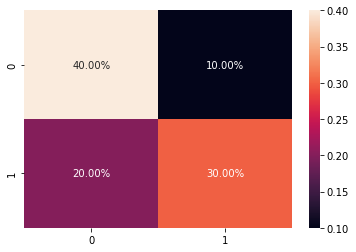

In [15]:
ac = accuracy_score(Y_test,clf_rf.predict(X_test))
print('Accuracy is: ', ac)

# we get the true negative, false pos, false negative and true pos 
# we see the percentage of the represented data in each quadrant 
cm = confusion_matrix(Y_test,clf_rf.predict(X_test))
sns.heatmap(cm/np.sum(cm),annot=True,fmt='.2%')

<AxesSubplot:>

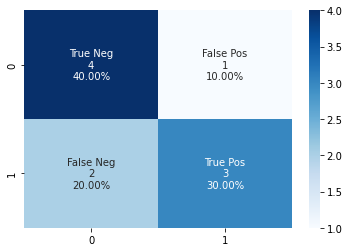

In [16]:
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

In [17]:
#def r2(clf_rf, X_train, Y_train):
#    return r2_score(Y_train, clf_rf.predict(X_train))

#perm_imp_rfpimp = permutation_importances(clf_rf, X_train, Y_train, r2)

In [ ]:
from sklearn.inspection import permutation_importance
r_rf = permutation_importance(clf_rf, X_test, Y_test,
                           n_repeats=10,
                           random_state=43)

TypeError: 'builtin_function_or_method' object is not iterable

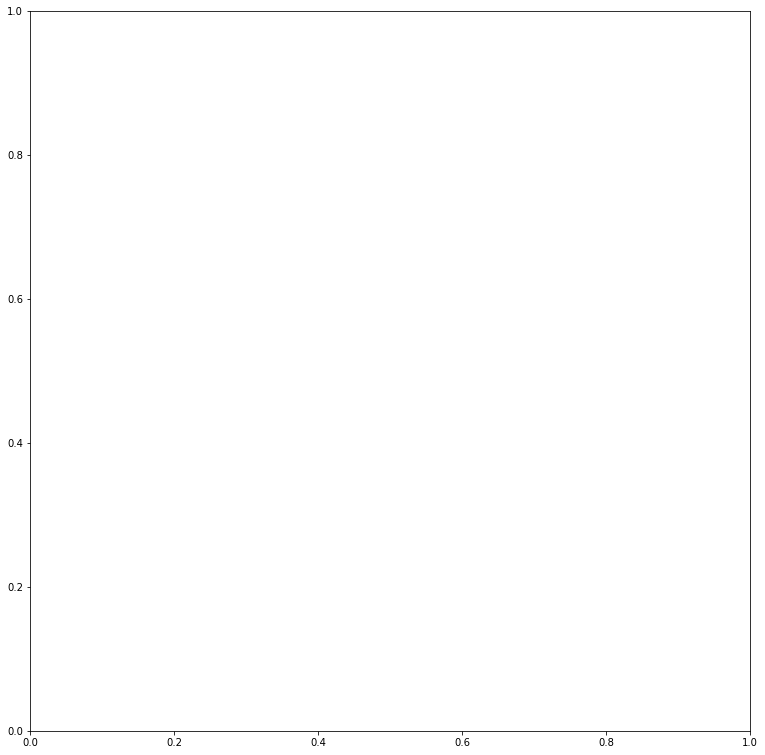

In [18]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])
flat_list = [item for sublist in r.values for item in sublist]
ax.bar(list(r.index),flat_list)
ax.set_xlabel('features')
ax.set_ylabel('feature_importance')
fig.autofmt_xdate(rotation=45)
plt.show()

### SVM with RNA only

In [19]:
# define models and parameters
model = sklearn.svm.SVC()
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
gamma = ['scale', 'auto'] # for poly, rbf, sigmoid

# define grid search
grid = dict(kernel=kernel, gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.865079 using {'gamma': 'scale', 'kernel': 'linear'}


In [20]:
clf_svm = sklearn.svm.SVC(kernel=grid_result.best_params_.get('kernel'), 
                  gamma=grid_result.best_params_.get('gamma'))     
clr_svm = clf_svm.fit(X_train,Y_train)

Accuracy is:  0.8


<AxesSubplot:>

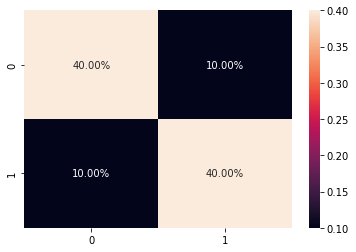

In [21]:
ac = accuracy_score(Y_test,clf_svm.predict(X_test))
print('Accuracy is: ', ac)

# we get the true negative, false pos, false negative and true pos 
# we see the percentage of the represented data in each quadrant 
cm = confusion_matrix(Y_test, clf_svm.predict(X_test))
sns.heatmap(cm/np.sum(cm),annot=True,fmt='.2%')

<AxesSubplot:>

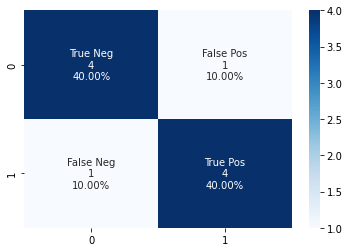

In [22]:
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

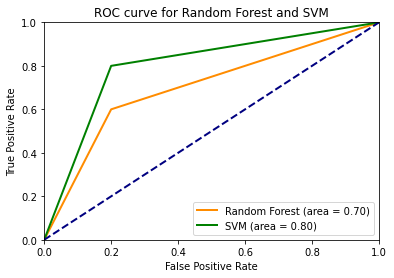

In [23]:
fpr_rf, tpr_rf, _ = roc_curve(Y_test, clf_rf.predict(X_test), pos_label=1)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_svm, tpr_svm, _ = roc_curve(Y_test, clf_svm.predict(X_test), pos_label=1)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure()
plt.plot(fpr_rf, tpr_rf, color="darkorange", lw=2,
         label="Random Forest (area = %0.2f)" % roc_auc_rf)
plt.plot(fpr_svm, tpr_svm, color="green", lw=2,
         label="SVM (area = %0.2f)" % roc_auc_svm)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for Random Forest and SVM")
plt.legend(loc="lower right")
plt.show()

In [24]:
r_svm = permutation_importance(clf_svm, X_test, Y_test,
                           n_repeats=10,
                           random_state=43)

TypeError: 'builtin_function_or_method' object is not iterable

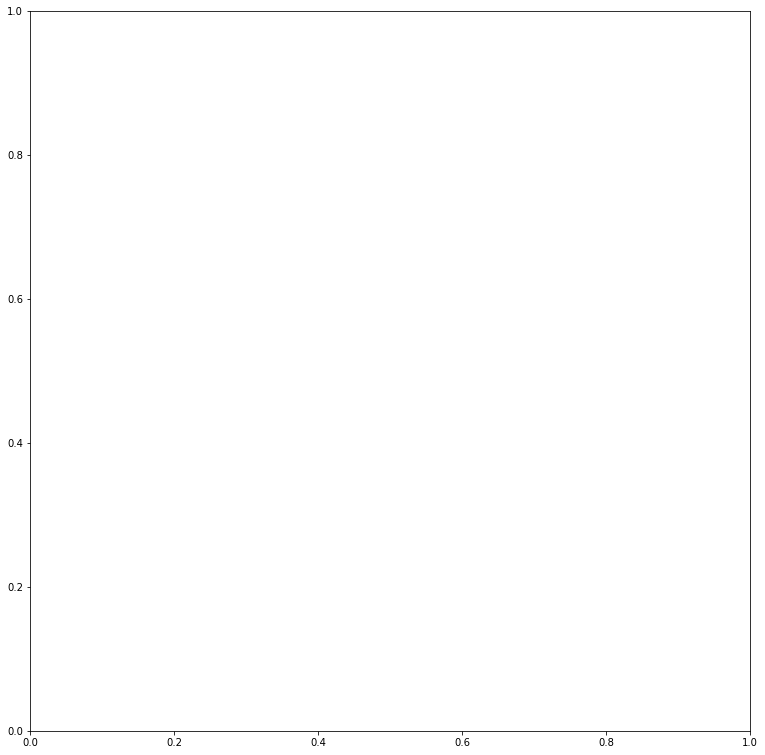

In [25]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])
flat_list = [item for sublist in r.values for item in sublist]
ax.bar(list(r.index),flat_list)
ax.set_xlabel('features')
ax.set_ylabel('feature_importance')
fig.autofmt_xdate(rotation=45)
plt.show()

In [29]:
print(r)

{'importances_mean': array([0., 0., 0., ..., 0., 0., 0.]), 'importances_std': array([0., 0., 0., ..., 0., 0., 0.]), 'importances': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])}
